In [10]:
# Sample calculations of magnetic corrections using iterative techniques
# Both precision and symmetric solutions are shown
# No linear algebra libraries are required. Simple matrix inversion routine is included
# No eigenvalue-eigenvector routines are required
# Works with Python Version 2.7
#
# Copyright 2020, Tom Judd 

from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('seaborn-poster')

import sys
import os

import pygame
import time
import socket
import struct
import math


In [11]:
iterations=7 #global Number of iterations 
verbose = 0  #global Prints more when verbose=1
plotMe  = 1  #global Plot of original vs corrected compass errors

# ============================= 
# simple matrix inversion
# assume well behaved data so no pivoting is used here

def mat_invert(A,epsilon=1E-10):
   
   N = len(A)

   Ainv=np.eye(N)
   
   for ii in range(N):
      alpha = A[ii][ii]
      if abs(alpha) < epsilon: return (Ainv,-1)
      
      for jj in range(N):
         A[ii][jj] =  A[ii][jj]/alpha
         Ainv[ii][jj] =  Ainv[ii][jj]/alpha 
      
      for kk in range(N):
         if kk==ii: continue
         beta = A[kk][ii]
         for jj in range(N):
            A[kk][jj]=A[kk][jj] - beta * A[ii][jj]
            Ainv[kk][jj]=Ainv[kk][jj] - beta * Ainv[ii][jj]
  
   return (Ainv,1)

 
# =============================  

def printVec( vec, sfmt="%9.4F", title="vec" ):
   ii = len(vec)
#   print "size: ", ii
   print( '\n',title,'(',ii,')')
   ss = " "
   for ix in range(ii):
      ari=np.real(vec[ix])
#      print ari
      sad =  sfmt % ari
      ss = ss + sad
   print ( ss )  
   return
 

# =============================  
  
def applyParams12(xyz,params):
   # first three of twelve parameters are the x,y,z offsets
   ofs=params[0:3]
   # next nine are the components of the 3x3 transformation matrix
   mat=np.reshape(params[3:12],(3,3))
   # subtract ofs
   xyzcentered=xyz-ofs
 
   xyzout=np.dot(mat,xyzcentered.T).T
   
   return xyzout
   
      

# =============================  
  
   
def analyticPartialRow(mag,acc,target,params):
   err0=magDotAccErr(mag,acc,target,params)
   # ll=len(params)
   slopeArr=np.zeros(12)
   slopeArr[0]=  -(params[3]*acc[0] + params[ 4]*acc[1] + params[ 5]*acc[2])
   slopeArr[1]=  -(params[6]*acc[0] + params[ 7]*acc[1] + params[ 8]*acc[2])
   slopeArr[2]=  -(params[9]*acc[0] + params[10]*acc[1] + params[11]*acc[2])
   
   slopeArr[ 3]= (mag[0]-params[0])*acc[0]
   slopeArr[ 4]= (mag[1]-params[1])*acc[0]
   slopeArr[ 5]= (mag[2]-params[2])*acc[0]
   
   slopeArr[ 6]= (mag[0]-params[0])*acc[1]
   slopeArr[ 7]= (mag[1]-params[1])*acc[1]
   slopeArr[ 8]= (mag[2]-params[2])*acc[1]
   
   slopeArr[ 9]= (mag[0]-params[0])*acc[2]
   slopeArr[10]= (mag[1]-params[1])*acc[2]
   slopeArr[11]= (mag[2]-params[2])*acc[2]
   
   return (err0,slopeArr)

# =============================  
   

# numeric version of calculating partial derivatives
   
def numericPartialRow(mag,acc,target,params,step,mode):
   
   err0=errFn(mag,acc,target,params,mode)   
   
   ll=len(params)
   slopeArr=np.zeros(ll)
   
   for ix in range(ll):
   
      params[ix]=params[ix]+step[ix]
      errA=errFn(mag,acc,target,params,mode) 
      params[ix]=params[ix]-2.0*step[ix]
      errB=errFn(mag,acc,target,params,mode) 
      params[ix]=params[ix]+step[ix]
      slope= (errB-errA)/(2.0*step[ix])
      slopeArr[ix]=slope
      
   return (err0,slopeArr)

   
# =============================  


def param9toOfsMat(params):
   ofs=params[0:3]
   mat=np.zeros(shape=(3,3))
   
   mat[0,0]=params[3]
   mat[1,1]=params[4]
   mat[2,2]=params[5]

   mat[0,1]=params[6]
   mat[0,2]=params[7]
   mat[1,2]=params[8]

   mat[1,0]=params[6]
   mat[2,0]=params[7]
   mat[2,1]=params[8]
   # print ofs,mat
   return (ofs,mat)

# =============================  
 
def ofsMatToParam9(ofs,mat,params):

   params[0:3]=ofs
   
   params[3]=mat[0,0]
   params[4]=mat[1,1]
   params[5]=mat[2,2]

   params[6]=mat[0,1]
   params[7]=mat[0,2]
   params[8]=mat[1,2]
  
   return params


# =============================  
   
#mode: 1=precision, use accels

def errFn(mag,acc,target,params,mode):
   if mode == 1: return magDotAccErr(mag,acc,target,params)
   return radiusErr(mag,target,params)

# =============================  
   
def radiusErr(mag,target,params):
   #offset and transformation matrix from parameters
   (ofs,mat)=param9toOfsMat(params)
   
   #subtract offset, then apply transformation matrix
   mc=mag-ofs
   mm=np.dot(mat,mc)

   radius = np.sqrt(mm[0]*mm[0] +mm[1]*mm[1] + mm[2]*mm[2] )
   err=target-radius
   return err
# =============================  
   
def magDotAccErr(mag,acc,mdg,params):
   #offset and transformation matrix from parameters
   ofs=params[0:3]
   mat=np.reshape(params[3:12],(3,3))
   #subtract offset, then apply transformation matrix
   mc=mag-ofs
   mm=np.dot(mat,mc)
   #calculate dot product from corrected mags
   mdg1=np.dot(mm,acc)
   err=mdg-mdg1
   return err
# =============================  

def mgDot(mag,acc):
   ll=len(mag)
   mdg=np.zeros(ll)
   for ix in range(ll):
      mdg[ix]=np.dot(mag[ix],acc[ix].T)
   # print mdg   
   avgMdg=np.mean(mdg)
   stdMdg=np.std(mdg)
   # print avgMdg,stdMdg/avgMdg
   return (avgMdg,stdMdg)
# =============================  
   
def normalize3(xyz):
   x=xyz[:,0]
   y=xyz[:,1]
   z=xyz[:,2]
   rarr = np.sqrt(x*x + y*y + z*z)
   ravg=np.mean(rarr)
   xyzn=xyz/ravg
   return (xyzn,ravg)
# =============================  
    
   
def errorEstimate(magN,accN,target,params):
   err2sum=0
   nsamp=len(magN)
   for ix in range(nsamp):
      err=magDotAccErr(magN[ix],accN[ix],target,params)
      err2sum += err*err
      # print "%10.6f" % (err)
   sigma=np.sqrt(err2sum/nsamp)  
   return sigma
# =============================  
   
def errorEstimateSymmetric(mag,target,params):
   err2sum=0
   nsamp=len(mag)
   for ix in range(nsamp):
      err=radiusErr(mag[ix],target,params)
      err2sum += err*err
      # print "%10.6f" % (err)
   sigma=np.sqrt(err2sum/nsamp)  
   return sigma  
# =============================  
   
def printParams(params,fmt='%10.6f',scale=1.0):

   ofs=np.array(params[0:3])
      # next nine are the components of the 3x3 transformation matrix
   mat=np.array(np.reshape(params[3:12],(3,3)))
   ofs*=scale
   mat*=scale
   # s0 = '"' + fmt + '"  "' + fmt + '"  "' +  fmt +  '"'
   s0 =  fmt + '  ' + fmt + '  ' +  fmt +  ' '
   # print s0
   ss=s0 % (ofs[0],ofs[1],ofs[2])
   print(ss,'\n')
   for ix in range(3):
      ss=s0 % (mat[ix,0],mat[ix,1],mat[ix,2])
      print(ss)
   print ('\n'   )
# =============================  
  
     
def printMat2( arr, sfmt="%9.4f", title="mat" ):
   ii = len(arr)
   jj = len(arr[0])
   print ('\n',title,'(',ii,',',jj,')')
#   print "size: ", ii, jj
   for ix in range(ii):
      ss = " "
      for jx in range (jj):
         arij=arr[ix][jx]
         # print sfmt
         sad =  sfmt % (arij)
         ss = ss + sad
      print (ss)
   return
# =============================  
   
def estimateCenter3D( arr, mode=0):

   # Slice off the component arrays
   xx=arr[:,0]
   yy=arr[:,1]
   zz=arr[:,2]
   
   #average point is centered sufficiently with well sampled data
   center=np.array([np.mean(xx),np.mean(yy),np.mean(zz)])
      
   #Center the samples
   xc=xx-center[0]
   yc=yy-center[1]
   zc=zz-center[2]
   
   # Calculate distance from center for each point 
   rc = np.sqrt(xc*xc + yc*yc + zc*zc)
   # Take the average
   radius = np.mean(rc)
   
   std = np.std(rc)
      
   return (center,radius,std)
# =============================
     
def ellipsoid_iterate_symmetric(mag,verbose):
      
   (centerE,magR,magSTD)=estimateCenter3D(mag)
  
   magScaled=mag/magR
   centerScaled = centerE/magR
     
   params9=np.zeros(9)
   ofs=np.zeros(3)
   mat=np.eye(3)
   params9=ofsMatToParam9(centerScaled,mat,params9)
  
   nSamples=len(magScaled)
   sigma = errorEstimateSymmetric(magScaled,1,params9)
   if verbose: print ('Initial Sigma',sigma)
  
   step=np.ones(9)  
   step/=5000
   D=np.zeros([nSamples,9])
   E=np.zeros(nSamples)
   nLoops=iterations

   for iloop in range(nLoops):

      for ix in range(nSamples):
         (f0,pdiff)=numericPartialRow(magScaled[ix],magScaled[ix],1,params9,step,0)
         E[ix]=f0
         D[ix]=pdiff
      DT=D.T
      DTD=np.dot(DT,D)
      DTE=np.dot(DT,E)
      invDTD=np.linalg.inv(DTD)
      deltas=np.dot(invDTD,DTE)

      p2=params9 + deltas
      
      (ofs,mat)=param9toOfsMat(p2)
      sigma = errorEstimateSymmetric(magScaled,1,p2)
    
      params9=p2
     
      if verbose: 
         print ('iloop',iloop,'sigma',sigma)
   
   return (params9,magR)   
   
    
   
# =============================
     
def ellipsoid_iterate(mag,accel,verbose):
      
   # magCorrected=copy.deepcopy(mag)
   # Obtain an estimate of the center and radius
   # For well distributed samples, the average of all points is sufficient
   
   (centerE,magR,magSTD)=estimateCenter3D(mag)
   
   #Work with normalized data
   magScaled=mag/magR
   centerScaled = centerE/magR
   
   (accNorm,accR)=normalize3(accel)
   
   params=np.zeros(12)
   #Use the estimated offsets, but our transformation matrix is unity
   params[0:3]=centerScaled
   mat=np.eye(3)
   params[3:12]=np.reshape(mat,(1,9))

   #initial dot based on centered mag, scaled with average radius
   magCorrected=applyParams12(magScaled,params)
   (avgDot,stdDot)=mgDot(magCorrected,accNorm)

   nSamples=len(magScaled)
   sigma = errorEstimate(magScaled,accNorm,avgDot,params)
   if verbose: print ('Initial Sigma',sigma)
   
   # pre allocate the data.  We do not actually need the entire
   # D matrix ( a nSamples x 12 matrix ) if we calculate DTD (a 12x12 matrix) within the sample loop
   # Also DTE (dimension 12) can be calculated on the fly. 
  
   D=np.zeros([nSamples,12])
   E=np.zeros(nSamples)
   
   #If numeric derivatives are used, this step size works with normalized data.
   step=np.ones(12)  
   step/=5000
   
   #Fixed number of iterations for testing.  In production you check for convergence
   
   nLoops=iterations

   for iloop in range(nLoops):
      # Numeric or analytic partials each give the same answer
      for ix in range(nSamples):
         # (f0,pdiff)=numericPartialRow(magScaled[ix],accNorm[ix],avgDot,params,step,1)
         (f0,pdiff)=analyticPartialRow(magScaled[ix],accNorm[ix],avgDot,params)
         E[ix]=f0
         D[ix]=pdiff
      #Use the pseudo-inverse   
      DT=D.T
      DTD=np.dot(DT,D)
      DTE=np.dot(DT,E)
      invDTD=np.linalg.inv(DTD)
      deltas=np.dot(invDTD,DTE)

      #negative sign because of the way we defined the derivatives
      p2=params + deltas
      
      
      sigma = errorEstimate(magScaled,accNorm,avgDot,p2)
      
      # add some checking here on the behavior of sigma from loop to loop
      # if satisfied, use the new set of parameters for the next iteration

      params=p2
      
      # recalculste gain (magR) and target dot product
      # not strictly required, the symmetric algorithm does not renormalice each loop
      
      magCorrected=applyParams12(magScaled,params)
      (mc,mcR)=normalize3(magCorrected)
      (avgDot,stdDot)=mgDot(mc,accNorm)
      magR *= mcR
      magScaled=mag/magR
      
      if verbose: 
         print ('iloop',iloop,'sigma',sigma)
   
   return (params,magR)
 
# =============================

def getCmdLine(argv,verbose): 
   fn=''
# file data is of form token,magx,magy,magz,accx,accy,accz,. . .    
   mcol=1
   acol=4
   token='V'
   argLen  = len(argv)
   if argLen < 2:
      print ('program [options]')
      print ('\t-f\tinput file name')
      
   kk=1
   while (argLen - kk) > 1:  #data comes in pairs '-z itemz'
      item = argv[kk]
      if verbose: print( kk,item)
      if len(item) < 2:
         kk+=1
         continue
      
      if item[0]!='-':
         kk+=1
         continue
      
      item = item.lower()
      
      if item[1] == 'f':
         fn=argv[kk+1]
               
      if verbose: print( kk+1,argv[kk+1]   )
      kk+=2
 
      
   return (fn,mcol,acol,token) 
   
# =============================


def str2float(ss,val): 
   try:
      rc=float(ss)
   except:
      return val #silent error
   return rc
   
# =============================
# Read input file generated by gendat.py

def readFileData(cmdlineStuff):

                  #items read from the file:
   dataList=[]    #observed samples
   swingList=[]   #level data points: 'S,mx,my,mz,...' simulating calibration data taked around a circle
   tcenter=[]     #true center, for comparison with calculations
   tmatrix=[]     #true transformation matrix, for comparison with calculations
   
   
   rc=(False,0,0,0,0,0) # return (ok,mag,accel,swingList,true center, true xform matrix )
   
   (fn,magix,accix,tok)=cmdlineStuff
   
   if not os.path.isfile(fn) :
      print('Could not open input file ' + fn)
      return rc
   try:
      f = open(fn,'rt')
      lines = f.readlines()
      f.close()
   except:
      print ('Could not open input file ' + fn)
      return rc
   
   for aLine in lines:
      aLine=aLine.strip()
      toks=aLine.split(',')
      
      
      if toks[0] == tok: # all samples have an identifying token
         if len(toks) < 7: continue # token,mx,my,mz,ax,ay,az = at least seven items 
         for ix, anItem in enumerate(toks):
            toks[ix] = str2float(anItem,0)
         dataList.append(toks[1:]) # start at 1, not 0, to eliminate token
         
      if toks[0] == 'S': # calibration points taken while the device is swung around 360 deg 
         if len(toks) < 4: continue # S,mx,my,mz = at least 4 samples
         for ix, anItem in enumerate(toks):
            toks[ix] = str2float(anItem,0)
         swingList.append(toks[1:4]) # drop the 'S' and save only mx,my,mz
         
      if toks[0] == 'T': # truth data: center, and transformation matrix 
      
         if len(toks) < 5: continue # 'T,center,cx,cy,cz' = at least 5 tokens
         if toks[1]=='center':
            for ix, anItem in enumerate(toks):
               tflt = str2float(anItem,0)
               if ix>1: tcenter.append(tflt) # start at index 2 = cx
            
            
         if len(toks) < 11: continue # 'T,matrix,m11,m12,m13,m21,m22,m23,m31,m32,m33'
         if toks[1]=='matrix':
            for ix, anItem in enumerate(toks):
               tflt = str2float(anItem,0)
               if ix>1: tmatrix.append(tflt) #saved here as 9 element linear array, not 3x3 
         
   
   if len(dataList) < 16: return rc  
   if len(swingList) < 8: return rc
   if len(tcenter) < 3: return rc
   if len(tmatrix) < 9: return rc
   
   dataArr=np.array(dataList)
   swingArr=np.array(swingList)

   tcenter=np.array(tcenter)
   tmatrix=np.reshape(np.array(tmatrix),(3,3)) #now a 3x3
   
   mag = dataArr[:,:3] #all rows, columns 0..2
   acc = dataArr[:,3:6] #all rows, columns 3..5
   
   return (True,mag,acc,swingArr,tcenter,tmatrix)
   

# =============================
def param9toParam12(p9):
   (ofs,mat)=param9toOfsMat(p9)
   p12=np.array(np.zeros(12))
   p12[:3]=ofs
   p12[3:12]=np.reshape(mat,(1,9))
   return p12
   
# =============================
def calculateAngleError(mag,params,magScale,swingPoints):
   swingCorrected=applyParams12(swingPoints/magScale,params)
   slen=len(swingPoints)   
   deltaDeg = 360/slen
   errO=np.array(np.zeros(slen))
   errC=np.array(np.zeros(slen))
   degArr=np.array(np.zeros(slen))
   
   for ix in range (slen):
      degTrue = ix*deltaDeg
      degArr[ix]=degTrue
      
      radObs=np.arctan2(swingPoints[ix,0],swingPoints[ix,1])
      degObs=-np.degrees(radObs)
      
      radCorrected=np.arctan2(swingCorrected[ix,0],swingCorrected[ix,1])
      degCorrected=-np.degrees(radCorrected)      
      
      diffO = degObs - degTrue
      
      if diffO < -180.0: diffO += 360.0
      if diffO >  180.0: diffO -= 360.0
      
      degObs = degTrue + diffO
      
      diffC = degCorrected - degTrue
      
      if diffC < -180.0: diffC += 360.0
      if diffC >  180.0: diffC -= 360.0
      
      degCorrected = degTrue + diffC
      
      errO[ix]=diffO
      errC[ix]=diffC

   avgO=np.mean(errO)   
   avgC=np.mean(errC)   
   errO-=avgO
   errC-=avgC
   stdO=np.std(errO)
   stdC=np.std(errC)
  
   return (stdO,stdC,errO,errC)

   
# =============================
def plotit360(dataArr,aTitle):
   
   (nvec,vlen)=dataArr.shape
  
   delta = int(360/vlen)
   
   xx=np.array(range(0,360,delta))
     
   fig, ax = plt.subplots()
   
   #expecting at least 3 arrays for ploting.
   ax.plot(xx,dataArr[0],'r')
   ax.plot(xx,dataArr[1],'b')
   ax.plot(xx,dataArr[2],'g')
   
   ax.set(xlabel='True Angle (deg)', ylabel='Compass Error (deg)', title=aTitle)
   ax.grid()
   plt.axis([0,360,-15,15]) 
   plt.show()

# =============================

In [12]:
# udp params
UDP_IP = "192.168.0.2" #192.168.0.05
UDP_PORT = 1333
print("UDP target IP: %s" % UDP_IP)
print("UDP target port: %s" % UDP_PORT)

def udp_init():
    sock = socket.socket(
        socket.AF_INET, # Internet
        socket.SOCK_DGRAM
    ) # UDP
    # allows sock to obtain data without stopping to wait for it
    
    sock.setblocking(1)

    # sock binds to the interfaces and uses port 1333
    #sock.detach()
    sock.bind(('', UDP_PORT))
    return sock

def joystick_init():
    pygame.display.init()
    pygame.joystick.init()
    pygame.joystick.Joystick(0).init()

    # Prints the values for axis0
    joystick = pygame.joystick.Joystick(0)
    return joystick

def init():
    sock = udp_init()
    joystick = joystick_init()
    return sock, joystick

def udp_send(sock, ip, port, message):
    sock.sendto(message, (UDP_IP, UDP_PORT))

##################################################################
#Code implemented from: https://www.youtube.com/watch?v=PQ27j8WAP8Q

def check_data():
    try:
        # Data received
        data, addr = sock.recvfrom(1024)
        #print("received message: %s from %s" % (data,addr))

        # return the decoded bytes as a string
        return data.decode()
    # If no data is received just return None
    except socket.error:
        return None



def dataMain():
    # Main loop
    #while True:
    # Check for UDP data
    line = check_data()
    # If there is data split it and print it to console
    if line:
        numvals += 1
        split_line = line.split(',')
        if split_line[0] == 1:
            otherstate = 1
            print(split_line)
            values.append(split_line[1:])
        elif split_line[0] == 2:
            otherstate = 2

sock, joystick = init()

UDP target IP: 192.168.0.2
UDP target port: 1333


In [20]:
def plotelipse(arr):
    x = arr[0]
    y = arr[1]
    z = arr[2]

    fig = plt.figure(figsize = (10,10))
    ax = plt.axes(projection='3d')
    ax.grid()
    length = int(len(x)/2)
    ax.scatter(x[0:length], y[0:length], z[0:length], c = 'r', s = 50)
    ax.scatter(x[length:], y[length:], z[length:], c = 'g', s = 50)
    ax.set_title('3D Scatter Plot')

    # Set axes label
    ax.set_xlabel('x', labelpad=20)
    ax.set_ylabel('y', labelpad=20)
    ax.set_zlabel('z', labelpad=20)
    plt.show()


In [14]:

l = 0.2 # meters
absz = 0
b_old = 0
b_state = 1
tauz = 0
fx = 0
state = 0


time_start = time.time()

In [24]:

mag = []
acc = []
numvals = 0
otherstate = 0

message = struct.pack('<fffffffffffff', 1,0,0,0,0,0,0,0,0,0,0,0,0) 
try:

    udp_send(sock, UDP_IP, UDP_PORT, message)
    while numvals < 500:
        
    
        line = check_data()
        # If there is data split it and print it to console
        if line:
            split_line = line.split(',')
            print(split_line)
            if split_line[0] == '1':
                numvals += 1
                otherstate = 1
                arr = []
                for x in split_line[1:]:
                    
                    arr.append(float(x))
                mag.append(arr[0:3])
                acc.append(arr[3:])
            elif split_line[0] == '2':
                otherstate = 2#prints out information from drone
            else:
                udp_send(sock, UDP_IP, UDP_PORT, message)
        else:
            udp_send(sock, UDP_IP, UDP_PORT, message)

        
        time.sleep(0.15)
        

except KeyboardInterrupt:
    print("The end")
    


['0.05', ' 0.01', ' -0.09', ' 0.04']
['0.05', ' -0.03', ' -0.10', ' 0.02']
['0.06', ' -0.05', ' -0.09', ' -0.01']
['0.08', ' -0.06', ' -0.09', ' -0.02']
['0.10', ' -0.07', ' -0.09', ' -0.01']
['0.11', ' -0.07', ' -0.09', ' -0.00']
['0.11', ' -0.09', ' -0.10', ' 0.04']
['0.11', ' -0.10', ' -0.11', ' 0.05']
['0.11', ' -0.10', ' -0.13', ' 0.10']
['0.09', ' -0.12', ' -0.17', ' 0.12']
['0.07', ' -0.12', ' -0.19', ' 0.10']
['0.04', ' -0.10', ' -0.21', ' 0.08']
['0.05', ' -0.10', ' -0.23', ' 0.07']
['0.07', ' -0.12', ' -0.24', ' 0.03']
['0.09', ' -0.12', ' -0.24', ' 0.02']
['0.09', ' -0.13', ' -0.22', ' -0.14']
['0.09', ' -0.16', ' -0.13', ' -0.34']
['0.10', ' -0.19', ' -0.12', ' -0.03']
['0.10', ' -0.25', ' -0.15', ' 0.12']
['0.11', ' -0.26', ' -0.21', ' 0.25']
['0.13', ' -0.23', ' -0.32', ' 0.42']
['0.12', ' -0.19', ' -0.43', ' 0.44']
['0.08', ' -0.18', ' -0.52', ' 0.36']
['0.06', ' -0.20', ' -0.58', ' 0.25']
['0.03', ' -0.22', ' -0.64', ' 0.21']
['0.02', ' -0.21', ' -0.71', ' 0.31']
['0.01

In [18]:

#==========
print ('\nPrecision calculation on magAccel400x data\n')

(params,magScale) = ellipsoid_iterate(np.array(mag),np.array(acc),1)
#printParams(params)
ofs=params[0:3]*magScale
printVec(ofs,'%10.2f','Offsets ')
mat=params[3:12]/params[3]#np.reshape(params[3:12],(3,3))
#printMat2(mat/mat[0,0],"%10.4f",'Transform Matrix norm1')
printVec(mat,'%10.2f','Matrix ')



Precision calculation on magAccel400x data

Initial Sigma 0.6066371819583452
iloop 0 sigma 0.05423335412218468
iloop 1 sigma 0.42435907609397916
iloop 2 sigma 0.20559806303794093
iloop 3 sigma 0.13957436301823853
iloop 4 sigma 0.13718707767153412
iloop 5 sigma 0.13671145993050843
iloop 6 sigma 0.13691709553218603

 Offsets  ( 3 )
      56.95    -65.43   -113.41

 Matrix  ( 9 )
       1.00    626.52   -154.56    648.34     35.63     88.65     71.25   -113.07   -728.23


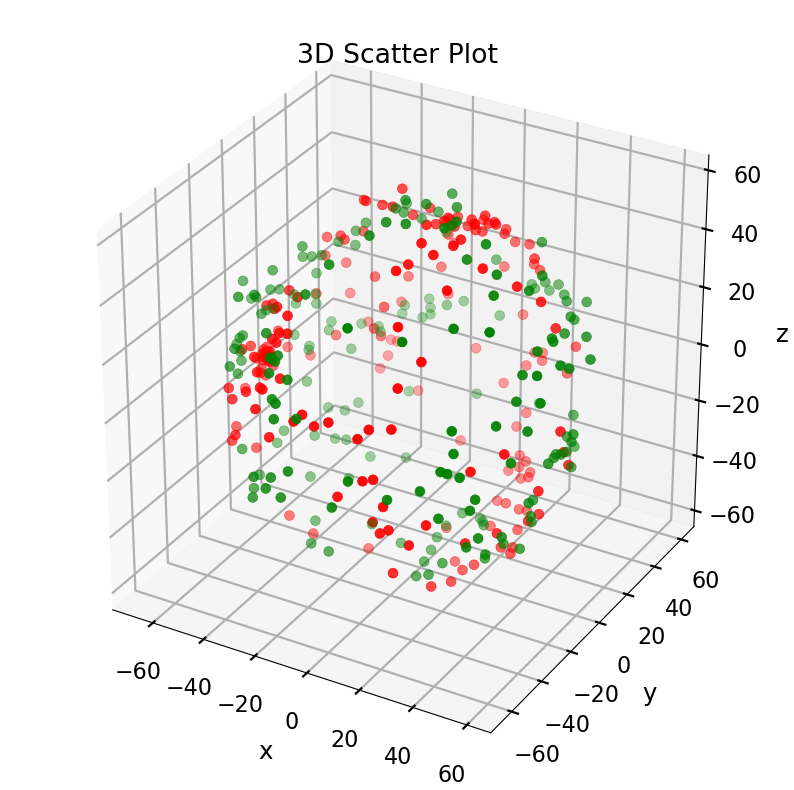

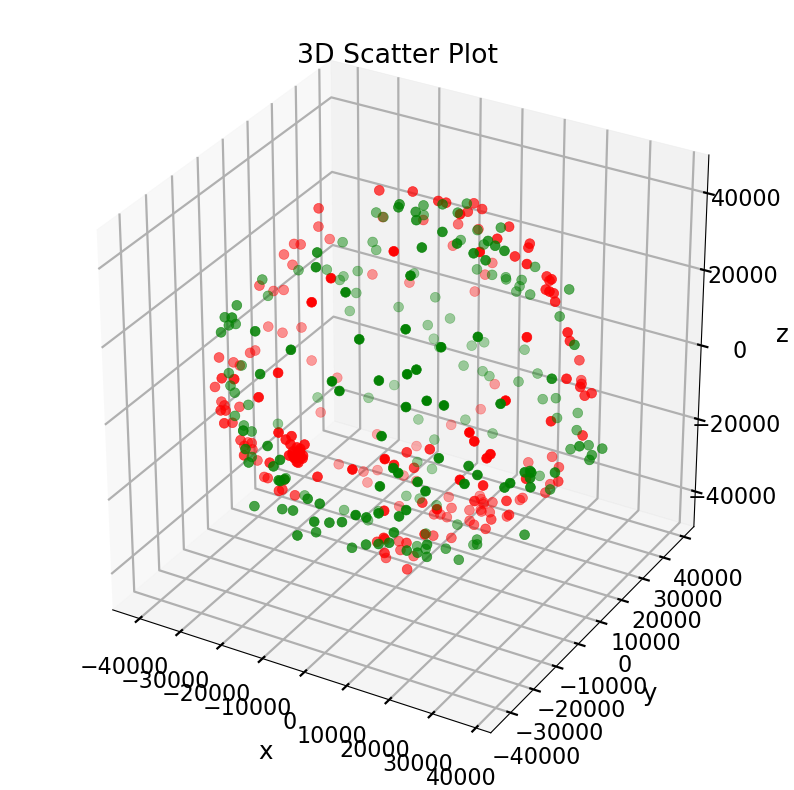

In [23]:

offsets = np.array(ofs)
transform  = np.reshape(mat,(3,3))


plotelipse(np.subtract(np.array(mag), offsets).T)

newmag = transform.dot(np.subtract(np.array(mag), offsets).T)
plotelipse(newmag)


In [ ]:
sock, joystick = init()
try:
    while otherstate != 2:
        message = struct.pack('<fffffffffffff', 2,  mat[0],mat[1],mat[2],
                                                    mat[3],mat[4],mat[5],
                                                    mat[6],mat[7],mat[8],
                                                    ofs[0],ofs[1],ofs[2]) 
        udp_send(sock, UDP_IP, UDP_PORT, message)
        #print(message)
        line = check_data()
        # If there is data split it and print it to console
        if line:
            split_line = line.split(',')
            print(split_line)
            if split_line[0] == '2':
                otherstate = 2#prints out information from drone
        #state = not state
        time.sleep(0.05) #0.005

except KeyboardInterrupt:
    print("The end")
    
